<a href="https://colab.research.google.com/github/FuturisticLover123/labs/blob/main/lab6/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#task1

In [2]:
import numpy as np
from scipy.stats import entropy

In [4]:
#task 1
def my_entropy(x, base = 1):
  _, counts = np.unique(x, return_counts=True)
  return -((counts / x.shape[0]) * np.log2(counts / x.shape[0])).sum()

print(my_entropy(np.array([1,1,1])))
print(entropy([1,1,1]))


-0.0
1.0986122886681096


In [5]:
#task2

In [7]:
from collections import Counter

class DisicionTree:
  def __init__(self, x, y, max_depth=3, max_leafs=10):
    self.max_leafs = max_leafs
    self.x, self.y = x, y
    self.root = self.Leaf(x, y, None)
    self.leafs = [self.root]
    self.max_depth = max_depth

  def information_gain(self, y, y_split):
    return my_entropy(y,base = 2) - (np.array([my_entropy(yi, base=2) for yi in y_split]) * np.array([len(yi) for yi in y_split])).sum() / len(y)

  def sort_rool(self, x):
    return sorted(x, key = lambda x: x[-1], reverse=True)[0]


  def predict(self, x):
    return self.root.predict(x)

  def split_one_leaf(self):
    leaf_stats = [(leaf,*self.best_split(leaf.x, leaf.y)) for leaf in self.leafs if leaf.depth <= self.max_depth and leaf.entropy > 0]
    if len(leaf_stats) == 0:
      return False
    leaf, feature, condition, _ = self.sort_rool(leaf_stats)#sorted(leaf_stats, key = lambda x: x[-1], reverse=True)[0]
    self.expand_leaf(leaf, feature, condition)
    return True

  def fit(self):
    while len(self.leafs) < self.max_leafs:
      if not self.split_one_leaf():
        return


  def expand_leaf(self, leaf, feature, condition):
    node = self.Node(feature, condition, leaf.x, leaf.y, leaf.parent, leaf.depth)

    self.leafs.append(node.left)
    self.leafs.append(node.right)

    if node.parent is None:
      self.root = node
    else:
      if node.parent.left is leaf:
        node.parent.left = node
      else:
        node.parent.right = node
    self.leafs.remove(leaf)


  def best_split(self, x, y):
    return self.sort_rool([self.one_feature_split(x, y, i) for i in range(x.shape[1])])
    #return sorted([self.one_feature_split(x, y, i) for i in range(x.shape[1])], key=lambda x: x[-1], reverse=True)[0]


  def one_feature_split(self, x, y, feature, k=10):
    sort_feature = x[:, feature]
    conditions = list()
    for _ in range(k):
      cond_ind = np.random.randint(len(sort_feature)-1)
      condition = (sort_feature[cond_ind] + sort_feature[cond_ind + 1]) / 2
      conditions.append((condition, self.information_gain(y, [y[sort_feature <= condition], y[sort_feature > condition]])))

    return feature, *self.sort_rool(conditions)
    #return feature, *sorted(conditions, key = lambda x: x[-1], reverse=True)[0]


  def score(self, x, y):
    out = np.array([self.predict(x_i) for x_i in x])
    return 1 - abs(y - out).sum() / len(y)


  class Node:
    def __init__(self, feature, condition, x,y, parent, depth=1):
      self.depth = depth
      self.parent = parent
      self.feature = feature
      self.condition = condition
      left = x[:, feature] <= condition
      right = x[:, feature] > condition
      self.left = DisicionTree.Leaf(x[left], y[left], self, self.depth + 1)
      self.right = DisicionTree.Leaf(x[right], y[right], self, self.depth + 1)


    def predict(self, x):
      if x[self.feature] <= self.condition:
        return self.left.predict(x)
      else:
        return self.right.predict(x)

  class Leaf:
    def __init__(self,x, y,parent, depth=1):
      self.entropy = my_entropy(y,base=2)
      self.parent = parent
      self.x, self.y = x, y
      self.depth = depth
      self.out = Counter(y).most_common()[0][0]
    def predict(self, x):
      return self.out

In [8]:
class GiniTree(DisicionTree):
  def information_gain(self, y, y_split):
    return 1 - ((np.array([len(yi) for yi in y_split]) / len(y))**2).sum()

  def sort_rool(self, x):
    return sorted(x, key = lambda x: x[-1])[0]



In [9]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
x,y = make_classification(100,10)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [10]:
# норм штука
tree = DisicionTree(x_train,y_train, max_depth=10, max_leafs=100)
tree.fit()
print(tree.score(x_train,y_train))
print(tree.score(x_test,y_test))

1.0
0.9


In [11]:
# адски жрет глубину
gini = GiniTree(x_train,y_train, max_depth=100, max_leafs=100)
gini.fit()
print(gini.score(x_train,y_train))
print(gini.score(x_test,y_test))

1.0
0.7


In [15]:
[leaf.entropy for leaf in gini.leafs];
[leaf.entropy for leaf in tree.leafs];

In [16]:
#встр
DecisionTreeClassifier(max_depth=10, max_leaf_nodes=100).fit(x_train,y_train).score(x_test,y_test)

0.95

In [17]:
#task3

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve

In [27]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [28]:

def trees_val_curve(X,y,param_range):
  train_scores, val_scores = validation_curve(
      DecisionTreeClassifier(),
      X, y,
      param_name="max_depth",
      param_range=param_range,
      cv=5,
      scoring="accuracy"
  )

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  val_mean = np.mean(val_scores, axis=1)
  val_std = np.std(val_scores, axis=1)

  plt.figure(figsize=(8, 6))
  plt.plot(param_range, train_mean, label="Training score", color="blue")
  plt.plot(param_range, val_mean, label="Validation score", color="red")

  plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
  plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)

  plt.title("Validation Curve with Decision Tree")
  plt.xlabel("Max Depth of Decision Tree")
  plt.ylabel("Accuracy")
  plt.legend(loc="best")
  plt.show()


In [29]:
# корабли

In [30]:
!kaggle competitions download -c titanic -p /content/sample_data/lab6
!unzip /content/sample_data/lab6/titanic.zip -d /content/sample_data/lab6

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/sample_data/lab6/titanic.zip
replace /content/sample_data/lab6/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [33]:
df = pd.read_csv('/content/sample_data/lab6/train.csv').fillna(method = 'ffill',axis=0)

<ipython-input-33-91670dd8f11d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv('/content/sample_data/lab6/train.csv').fillna(method = 'ffill',axis=0)


In [34]:
_ = df.drop(columns=["Survived","Name","Sex","Ticket","Cabin","Embarked"]).dropna().corr()
_.style.background_gradient(cmap='coolwarm')

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.035144,0.026653,-0.057527,-0.001652,0.012658
Pclass,-0.035144,1.000000,-0.291157,0.083081,0.018443,-0.549500
Age,0.026653,-0.291157,1.000000,-0.206104,-0.165191,0.083417
SibSp,-0.057527,0.083081,-0.206104,1.000000,0.414838,0.159651
Parch,-0.001652,0.018443,-0.165191,0.414838,1.000000,0.216225
Fare,0.012658,-0.549500,0.083417,0.159651,0.216225,1.000000


In [35]:
fixed_data = pd.get_dummies(df.drop(columns=["Name","Ticket","Cabin","Embarked"]),columns=['Sex',"Pclass"]).astype(float)
y = fixed_data.Survived
X = fixed_data.drop(columns=["Survived"])

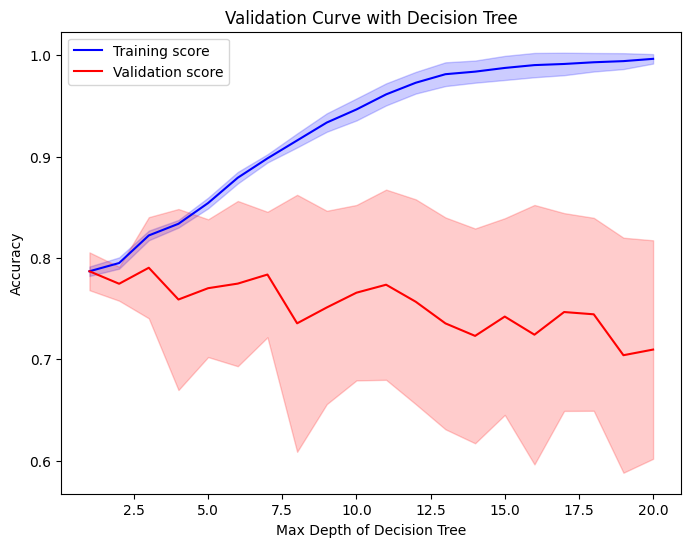

In [36]:
param_range = np.arange(1, 21)
trees_val_curve(X,y,param_range)

In [ ]:
# диабеты

In [37]:
!kaggle datasets download -d saurabh00007/diabetescsv -p /content/sample_data/lab6
!unzip /content/sample_data/lab6/diabetescsv.zip -d /content/sample_data/lab6

Dataset URL: https://www.kaggle.com/datasets/saurabh00007/diabetescsv
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 15.3MB/s]
Archive:  /content/sample_data/lab6/diabetescsv.zip
  inflating: /content/sample_data/lab6/diabetes.csv  


In [38]:
df = pd.read_csv('/content/sample_data/lab6/diabetes.csv').fillna(method = 'ffill',axis=0)
df.head()

<ipython-input-38-79e77b0d56e8>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv('/content/sample_data/lab6/diabetes.csv').fillna(method = 'ffill',axis=0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [39]:
_ = df.corr()
_.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [40]:
y = df.Outcome
X = df.drop(columns=["Outcome"])

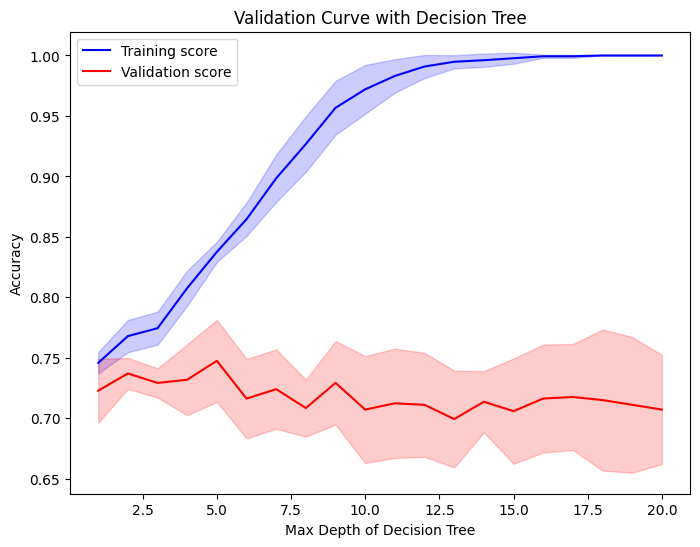

In [41]:
param_range = np.arange(1, 21)
trees_val_curve(X,y,param_range)

In [ ]:
# цветочки

In [42]:
!kaggle datasets download -d uciml/iris -p /content/sample_data/lab6
!unzip /content/sample_data/lab6/iris.zip -d /content/sample_data/lab6

Dataset URL: https://www.kaggle.com/datasets/uciml/iris
License(s): CC0-1.0
  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 6.33MB/s]
Archive:  /content/sample_data/lab6/iris.zip
  inflating: /content/sample_data/lab6/Iris.csv  
  inflating: /content/sample_data/lab6/database.sqlite  


In [43]:
df = pd.read_csv('/content/sample_data/lab6/Iris.csv').fillna(method = 'ffill',axis=0)
df.head()

<ipython-input-43-f5ca18754848>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv('/content/sample_data/lab6/Iris.csv').fillna(method = 'ffill',axis=0)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [44]:
_ = df.drop(columns=["Species"]).corr()
_.style.background_gradient(cmap='coolwarm')

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,1.000000,0.716676,-0.397729,0.882747,0.899759
SepalLengthCm,0.716676,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.397729,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.882747,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.899759,0.817954,-0.356544,0.962757,1.000000


In [45]:
y = df.Species
X = df.drop(columns=["Species"])

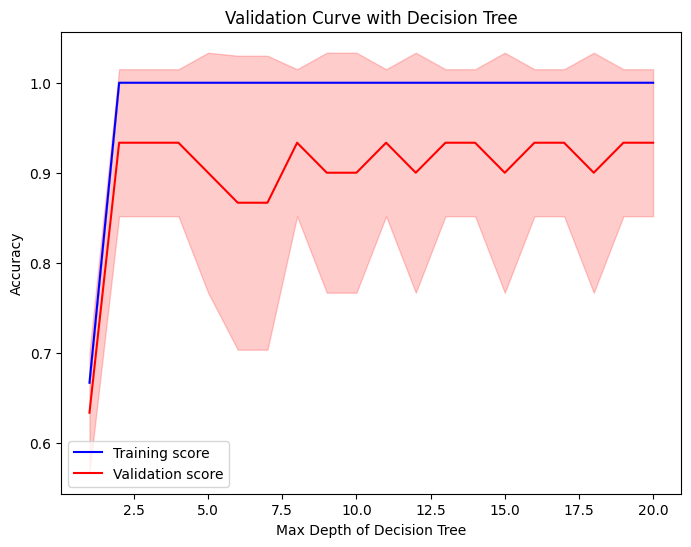

In [46]:
param_range = np.arange(1, 21)
trees_val_curve(X,y,param_range)

In [ ]:
# грибы

In [47]:
!kaggle datasets download -d uciml/mushroom-classification -p /content/sample_data/lab6
!unzip /content/sample_data/lab6/mushroom-classification.zip -d /content/sample_data/lab6

Dataset URL: https://www.kaggle.com/datasets/uciml/mushroom-classification
License(s): CC0-1.0
  0% 0.00/34.2k [00:00<?, ?B/s]
100% 34.2k/34.2k [00:00<00:00, 8.91MB/s]
Archive:  /content/sample_data/lab6/mushroom-classification.zip
  inflating: /content/sample_data/lab6/mushrooms.csv  


In [48]:
df = pd.read_csv('/content/sample_data/lab6/mushrooms.csv').fillna(method = 'ffill',axis=0)
df.head()

<ipython-input-48-87d443a86e9a>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv('/content/sample_data/lab6/mushrooms.csv').fillna(method = 'ffill',axis=0)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [49]:
x = pd.get_dummies(df.drop(columns=["class"]), columns=df.drop(columns=["class"]).columns).astype(float)
y = df["class"]

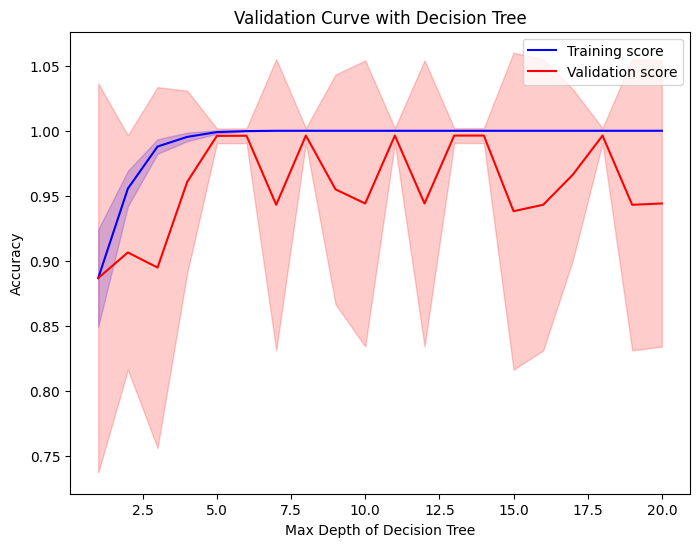

In [50]:
param_range = np.arange(1, 21)
trees_val_curve(x,y,param_range)

In [51]:
#task4

In [52]:
class RegressionTree(DisicionTree):
  def information_gain(self, y, y_split):
    return ((y - y.mean()) ** 2).sum() / len(y) - np.array([((yi - yi.mean())**2).sum() / len(yi) for yi in y_split]).sum()

  def sort_rool(self, x):
    return sorted(x, key = lambda x: x[-1], reverse=True)[0]

  def score(self, x, y):
    out = np.array([self.predict(xi) for xi in x])
    return 1 - ((y - out) @ (y - out))  /  ((y - y.mean()) @ (y - y.mean()))

  class Leaf:
    def __init__(self,x, y,parent, depth=1):
      self.entropy = 1
      self.parent = parent
      self.x, self.y = x, y
      self.depth = depth
      self.out = np.mean(y)

    def predict(self, x):
      return self.out

In [54]:
from sklearn.datasets import make_regression
x,y = make_regression(100,10)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

0.928090939132314
0.10676520065833983


In [66]:
# переобучаются капец как
rgtree = RegressionTree(x_train,y_train, max_depth=17, max_leafs=100)
rgtree.fit()

print(rgtree.score(x_train,y_train))
print(rgtree.score(x_test,y_test))

0.9999980372794206
0.11598862322438741
